In [1]:
%matplotlib inline

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
from pathlib import Path

In [5]:
# Database setup
database_path= Path("resources/hawaii.sqlite")

In [6]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")

In [7]:
# reflect an existing database into a new model
Base =automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_12444\2163080669.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine,reflect=True)


In [8]:
# View all of the classes that automap found
print(Base.classes.keys())



['measurement', 'station']


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session =Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date

'2017-08-23'

<Figure size 1000x600 with 0 Axes>

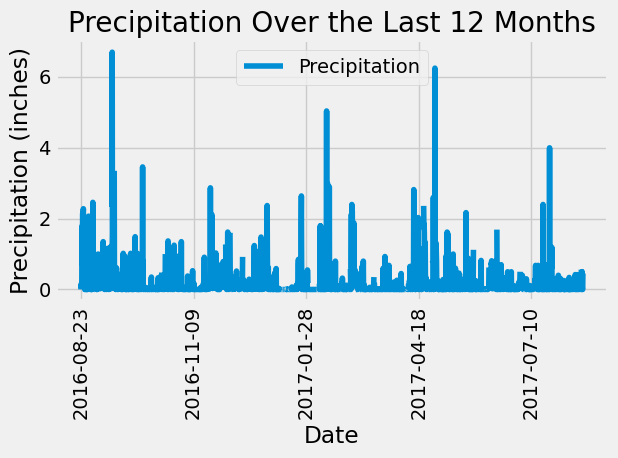

In [12]:
# Calculate the date one year from the last date in dataset
one_year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= one_year_ago_date).\
                        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and explicitly set the column names
precipitation_df_alt = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
precipitation_df_alt.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))

precipitation_df_alt.plot(x='Date', y='Precipitation', rot=90)

plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats_alt = precipitation_df_alt.describe()
print(summary_stats_alt)

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print("Most Active Stations:")
for station in most_active_stations:
    print(station)

Most Active Stations:
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()
print("Temperature Statistics for the Most Active Station:")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")

Temperature Statistics for the Most Active Station:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


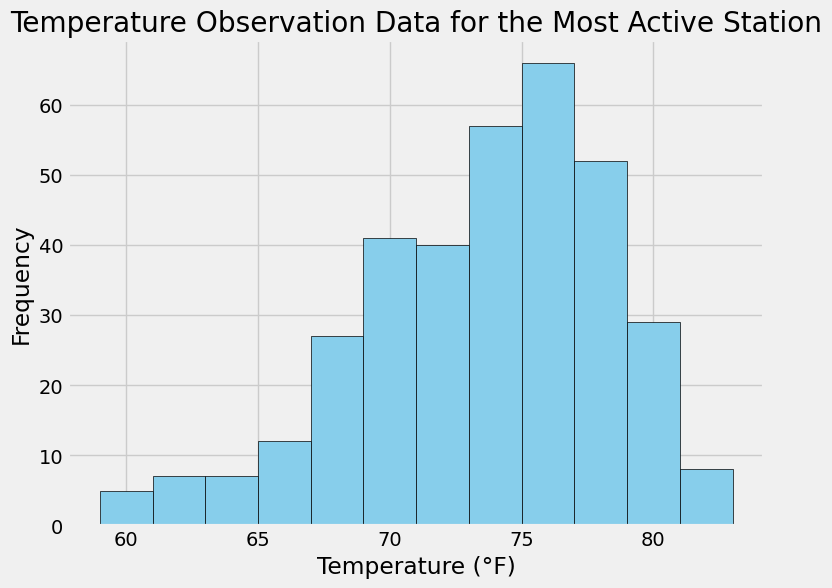

In [17]:
# Query the last 12 months of temperature observation data for the most active station
last_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query result to a list of temperatures
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, color='skyblue', edgecolor='black')
plt.title('Temperature Observation Data for the Most Active Station')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()